# <div align="center"><b> APSERa Simulation Pipeline </b></div>


## **<div align="center"><b> Importing required packages </b></div>**


In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import math
import ephem
from scipy.signal import correlate

from scipy.optimize import curve_fit

%matplotlib inline
from scipy.signal import savgol_filter
from pygsm import GlobalSkyModel
from ms_fit_joint_inf import ms_fit_inf, chisq_poly
import maxsmooth
from maxsmooth.DCF import smooth

from astropy.timeseries import TimeSeries, BinnedTimeSeries
from astropy.time import Time, TimeDelta
from astropy.coordinates import Galactic, SkyCoord, FK5, EarthLocation, AltAz, Angle
import astropy.units as u

import pandas as pd
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline, RegularGridInterpolator



## **<div align="center"><b> Time and number of spectra </b></div>**


In [2]:
start_time_in_UTC = '2012-05-19 19:45:00'
n_spectra = 1                 #Number of spectra to be taken
delta_t_in_hours = 1            #Time interval between each spectra needed in hours


t = Time(start_time_in_UTC, format = 'iso', scale= 'utc')

ts = TimeSeries(time_start= start_time_in_UTC, time_delta= delta_t_in_hours *u.hour, n_samples= n_spectra)
ts = ts.time
print(ts)

['2012-05-19 19:45:00.000']


In [18]:
import os
import glob
import numpy as np
from scipy import interpolate


#beam_path = "/home/dhashin/workspace/APSERa/ERA_data_files-20220628T065909Z-001/ERA_data_files/Files_by_Keerthi/Farfield/"   
beam_path = "/home/dhashin/workspace/APSERa/ERA_data_files-20220628T065909Z-001/ERA_data_files/"
#rt_file    = '/home/dhashin/workspace/APSERa/ERA_data_files-20220628T065909Z-001/ERA_data_files/Files_by_Keerthi/s11.txt'
rt_file    = '/home/dhashin/workspace/APSERa/ERA_data_files-20220628T065909Z-001/ERA_data_files/s11_linear.txt'
#rt_file = 's11_linear.txt'

#file_list  = sorted(glob.glob(os.path.join(beam_path,"*1].txt")))
file_list = sorted(glob.glob(os.path.join(beam_path,"*ghz.txt")))


gamme_file = os.path.join(beam_path, rt_file)

gamma_freq = []
gamma_val  = []

with open(gamme_file) as fa:
    for line_aa in fa.readlines()[3:]:
        line_aa = line_aa.strip()
        col1    = line_aa.split('\t')
        _freq   = np.array(list(map(float, col1[0].split())))[0]
        _val    = np.array(list(map(float, col1[1].split())))[0]
        gamma_freq.append(_freq)
        gamma_val.append(_val)
        
gamma_freq = np.array(gamma_freq)
gamma_val  = np.array(gamma_val)

print(gamma_freq)
print(gamma_val)

gamma_val = np.power(10, gamma_val/20)
gamma_val = gamma_val/ np.max(gamma_val)


gamma_func = interpolate.interp1d(gamma_freq, gamma_val)

print(gamma_func(2))

phi_res   = 1
theta_res = 1

phi_array   = np.arange(0, 361, phi_res)
theta_array = np.arange(-90, 90 + theta_res, theta_res)
freq_array  = []
file_array  = []

# def get_freq_from_file(filename):
#     _temp = os.path.basename(filename).replace(') [1].txt','').replace('farfield (f=','')
#     print(_temp)
#     return float(_temp)


def get_freq_from_file(filename):
    _temp = os.path.basename(filename).replace('.txt','').replace('ghz','')
    return float(_temp)
    
for ii, file_add in enumerate(file_list):
    freq_array.append(get_freq_from_file(file_add))
    file_array.append(file_add)
    
#print(get_freq_from_file('2.1ghz.txt'))
    
np.testing.assert_array_equal(file_array, file_list)

freq_array = np.array(freq_array)
file_array = np.array(file_array)

isort      = np.argsort(freq_array)
freq_array = freq_array[isort]
file_array = file_array[isort]

beam_3D_unnorm = np.zeros((len(freq_array), len(theta_array), len(phi_array)))

for ii, freq in enumerate(freq_array):
    print("Processing frequency {:.2f} GHz".format(freq))
    file_add = file_array[ii]
    with open(file_add) as fa:
        for line_aa in fa.readlines()[2:]:
            line_aa = line_aa.strip()
            col1    = line_aa.split('\t')
            all_val = np.array(list(map(float, col1[0].split())))

            theta   = 90 - all_val[0]                      #all_val[0] - 90   - Check again for correction
            phi     = all_val[1]
            beam    = all_val[2]
            

            iphi    = np.where(phi_array==phi)[0][0]
            itheta  = np.where(theta_array==theta)[0][0]
            beam_3D_unnorm[ii, itheta, iphi] = beam


beam_3D = np.zeros((len(freq_array), len(theta_array), len(phi_array)))

#print(beam_3D_unnorm[0, :,:].shape)


for ifreq in range(beam_3D.shape[0]):
    for itheta in range(beam_3D.shape[1]):
        for iphi in range(beam_3D.shape[2]):
            beam_3D[ifreq, itheta,iphi] = beam_3D_unnorm[ifreq, itheta,iphi]/np.amax(beam_3D_unnorm[ifreq,:,:])
            beam_3D[ifreq, itheta,iphi] = beam_3D[ifreq, itheta,iphi]/ (1 - (gamma_func(freq_array[ifreq]))**2)


print(freq_array)    

        
theta_array_new = theta_array
phi_array_new   = phi_array

from scipy.interpolate import RegularGridInterpolator
my_interpolating_function = RegularGridInterpolator((freq_array, theta_array_new,
                                                     phi_array_new), beam_3D)



#Beam definition

%matplotlib notebook

PI = math.pi



[2.         2.00200009 2.00399995 ... 3.99600005 3.99799991 4.        ]
[0.16108168 0.16355578 0.16606546 ... 0.238724   0.23752456 0.23632947]
0.9484414625275973
Processing frequency 2.00 GHz
Processing frequency 2.10 GHz
Processing frequency 2.20 GHz
Processing frequency 2.30 GHz
Processing frequency 2.40 GHz
Processing frequency 2.50 GHz
Processing frequency 2.60 GHz
Processing frequency 2.70 GHz
Processing frequency 2.80 GHz
Processing frequency 2.90 GHz
Processing frequency 3.00 GHz
Processing frequency 3.10 GHz
Processing frequency 3.20 GHz
Processing frequency 3.30 GHz
Processing frequency 3.40 GHz
Processing frequency 3.50 GHz
Processing frequency 3.60 GHz
Processing frequency 3.70 GHz
Processing frequency 3.80 GHz
Processing frequency 3.90 GHz
Processing frequency 4.00 GHz
[2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7
 3.8 3.9 4. ]


<IPython.core.display.Javascript object>


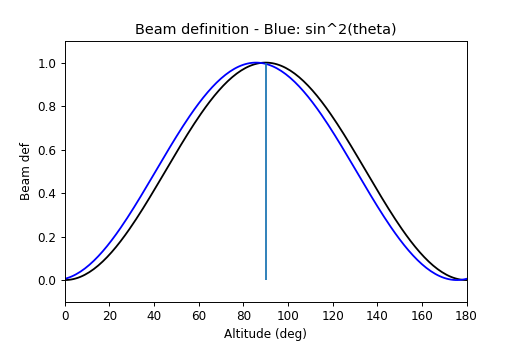

78.0
102.0


In [33]:
%matplotlib notebook

PI = math.pi
check_alt = np.linspace(0,180,181)

check_yy = (np.sin((check_alt - 1*(2-3))*PI/180)*np.sin((check_alt - 1*(2-3))*PI/180))
#check_yyy = (np.sin((check_alt-5*0.0174533)*PI/180)*np.sin((check_alt-5*0.0174533)*PI/180))
check_y = (np.sin(check_alt*PI/180)*np.sin(check_alt*PI/180)) 
#check_yy = check_y + 0.25*(np.sin(2*check_alt*PI/180))*(np.sin(2*check_alt*PI/180)) 

wob_1d = 0
stretch = 0.25
c_yyy = (1/np.max((np.sin((check_alt)*PI/180)*np.sin((check_alt)*PI/180)) * np.cos(0.5*(check_alt)*PI/180)))*(np.sin((check_alt)*PI/180)*np.sin((check_alt)*PI/180)) * np.cos(0.5*(check_alt)*PI/180)# + stretch*(np.sin(2*check_alt*PI/180))*(np.sin(2*check_alt*PI/180))
c_xxx = (1/np.max((np.sin((check_alt)*PI/180)*np.sin((check_alt)*PI/180)) * np.cos(0.5*(check_alt*PI/180 - PI))))*(np.sin((check_alt)*PI/180)*np.sin((check_alt)*PI/180)) * np.cos(0.5*(check_alt*PI/180 - PI))
c_zzz = (np.sin((check_alt - math.cos(210 * PI/180)* 5 * (3 - 2)) * PI/180))**2


plt.plot(check_alt, check_y, color = 'black')
plt.plot(check_alt, c_zzz, color = 'blue')
#plt.plot(check_alt, c_xxx, color = 'red')
plt.xlim([0, 180])
plt.vlines(90, ymin = 0, ymax = 1)
plt.ylim([-0.1, 1.1])
#plt.plot(check_alt, check_yyy, color = 'blue')
plt.title('Beam definition - Blue: sin^2(theta)')
plt.xlabel('Altitude (deg)')
plt.ylabel('Beam def')
plt.show()

print(check_alt[np.argmax(c_yyy)])
print(check_alt[np.argmax(c_xxx)])


#array = np.random.normal(0,0.5,No_of_Channels)
def beam_def(freq, alt, az):
#     return float(my_interpolating_function([freq, alt, az]))
    if (alt<=0):
        return 0
    else:
        
        #i = int(10*(freq-1.8))
        #perturb = float(array[i])
        
        #Randomly perturbed:
        #return (math.sin((alt-perturb)*PI/180)*math.sin((alt-perturb)*PI/180))
        
        #sin^2(theta) beam perturbed:
        #return (math.sin((alt-0.5*(freq - 3))*PI/180)*math.sin((alt-0.5*(freq - 3))*PI/180))
        
        #sin^2(2theta) beam perturbed:
        #return (math.sin(2*(alt-1.1*(freq - 3))*PI/180)*math.sin(2*(alt-1.1*(freq - 3))*PI/180))
        
        #Unperturbed beam pattern:
        return (math.sin(alt*PI/180)*math.sin(alt*PI/180)) #+ 1.0*(math.sin(2*alt*PI/180))*(math.sin(2*alt*PI/180)) 
        

        


In [30]:
def beam_def(freq, alt, az):

    if az > 180:
        alt = 180 - alt 

    if (alt<0):
        return 0       
    else:
        #return (math.cos((alt-20*(freq - 3))*PI/180)*math.cos((alt-20*(freq - 3))*PI/180))
        #return (math.sin(alt*PI/180)*math.sin(alt*PI/180)) + (freq - 3)*0.25*(math.sin(2*alt*PI/180))*(math.sin(2*alt*PI/180)) 
        return (1/np.max((np.sin((check_alt)*PI/180)*np.sin((check_alt)*PI/180)) * np.cos(0.48*(check_alt*PI/180 - ((freq - 2)/2)*PI))))*(np.sin((alt)*PI/180)*np.sin((alt)*PI/180)) * np.cos(0.48*(alt*PI/180 - ((freq - 2)/2)*PI))

for 


array([-2.141592653589793, -2.141592653589793, -2.141592653589793])

## **<div align="center"><b> Definitions </b></div>**

In [11]:
h = 6.62607157e-34
k = 1.3806488e-23
c = 2.99792458e+08
TCMB = 2.72548
f_start = 2.0
f_stop = 4.0
No_of_Channels = 201
Channel_width = 0.01
N_SIDE = 64
T_hot = 3730
T_cold = 2730                    #T_cold and T_hot in Kelvins
Time_in_UTC = ts
latitude = 12.9716
longitude = 77.5946           #Latitude and longitude in degrees
altitude = 920                 #Altitude in meters
alpha = 0.0065                   #Temp. lapse rate (deg C per meter)
PI = 3.14159265
Noise_int_time = 3e+12
Trx = 14
T_atm = 1
freqs = np.linspace(f_start,f_stop, No_of_Channels)
CMB_Int = np.empty([No_of_Channels])
P_hot = np.empty(No_of_Channels)
P_cold = np.empty(No_of_Channels)
P_dif = np.empty(No_of_Channels)
cross_real = [0]*No_of_Channels
cross_imag = [0]*No_of_Channels
final_temp = [0]*No_of_Channels
sumwt = [0]*No_of_Channels
sigma = [0]*No_of_Channels
spectra = [0]*n_spectra
spectra_cross_imag = [0]*n_spectra
NPIX = hp.nside2npix(N_SIDE)


#Refraction correction formula
def refraction(alt_in_deg, altitude):
    pres = 1010.*math.pow((1-6.5/288000*altitude),5.255)
    if (altitude>11000):
        temp = 211.5
    else:
        temp = 283.0 - (alpha * altitude)
    R = 1.02/math.tan((alt_in_deg + (10.3/(alt_in_deg + 5.11)))*(PI/180))
    if (alt_in_deg == 90):
        R = R+ 0.0019279
    tpcor = (pres/1000) * (283/temp)
    R =  tpcor*(R/60)
    return alt_in_deg +R


start_time_in_UTC = '2024-05-19 20:00:00.000'
n_spectra = 1                 #Number of spectra to be taken
delta_t_in_hours = 1            #Time interval between each spectra needed in hours

t = Time(start_time_in_UTC, format = 'iso', scale= 'utc')

ts = TimeSeries(time_start= start_time_in_UTC, time_delta= delta_t_in_hours *u.hour, n_samples= n_spectra)
ts = ts.time
print(ts)




Obs = ephem.Observer()
t = Time(ts[0], scale='utc',location= EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg, height=altitude*u.m))
lst = t.sidereal_time('apparent')
print(lst)

['2024-05-19 20:00:00.000']
17h02m17.32850041s


In [13]:
#Finding the part of sky visible at our UTC (when reading is taken)

    
plt.plot(check_alt, (np.sin((check_alt-5*(4 - 3))*PI/180)*np.sin((check_alt-5*(4 - 3))*PI/180)), label = "At 4 GHz")
plt.plot(check_alt, (np.sin((check_alt-5*(2 - 3))*PI/180)*np.sin((check_alt-5*(2 - 3))*PI/180)), label = "At 2 GHz")
#plt.xlim([0,90])
plt.xlabel("Altitude (deg)")
plt.ylabel("sin^2(theta)")
plt.legend()
plt.grid()
plt.show()


gsm = GlobalSkyModel(freq_unit='GHz')

def Visible_Sky(frequency, latitude, longitude, altitude, T, pert):           #Here frequency is taken in GHz, lat and lon in degrees and T is the format 'YYYY-MM-DD HH:MM:SS.SS'
    spectrum_weighted_added = 0
    def beam_def(freq, alt, az):
#         return float(my_interpolating_function([freq, alt, az]))
        if (alt<=0):
            return 0
        else:
            return (math.sin((alt-5*(freq - 3))*PI/180)*math.sin((alt-5*(freq - 3))*PI/180))

    #Refraction correction formula
    def refraction(alt_in_deg, altitude):
        pres = 1010.*math.pow((1-6.5/288000*altitude),5.255)
        if (altitude>11000):
            temp = 211.5
        else:
            temp = 283.0 - (alpha * altitude)
        R = 1.02/math.tan((alt_in_deg + (10.3/(alt_in_deg + 5.11)))*(PI/180))
        if (alt_in_deg == 90):
            R = R+ 0.0019279
        tpcor = (pres/1000) * (283/temp)
        R =  tpcor*(R/60)
        return alt_in_deg +R
    
    
    
    spectrum = gsm.generate(frequency)
    spectrum = hp.pixelfunc.ud_grade(spectrum, 16)                      #Reducing the resolution to NSIDE=16

    i=1

    while i<NPIX:           #Working on each pixel
        if (i%1000 == 0): print(i)
        coords = hp.pixelfunc.pix2ang(16, i , nest = False, lonlat = True)          #Gives l and b coordinates for each pixel
        gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below
        equi = gc.transform_to(AltAz(obstime = T, location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg, height=altitude*u.m)))
        
        alt = equi.alt.value
        new_alt = refraction(alt, altitude) 
        longitudes = equi.az.value
        cwt = beam_def(frequency, new_alt, longitudes)
#         if (cwt > 1): 
#             print("Oh no!:  ", cwt)
        spectrum[i-1] = (1 - cwt)* spectrum[i-1]
    
        
        
        
#         # If alt<0 in horizontal coordinates, that is not visible for the observer. So, suxh pixels are given minimum value (grey in map)
#         if (new_alt<0):
#             spectrum[i-1] = -1.6375e+30
#         else: 
#             spectrum_weighted_added = spectrum_weighted_added + spectrum[i-1]
        
    
        i = i+1  
        
#     if frequency == 2.0:
#         global spectrum_to_divide
#         spectrum_to_divide = spectrum
#         alpha = np.ones(len(spectrum))
#     else: 
#         global alpha1
#         alpha1 = np.log(spectrum / spectrum_to_divide)/ np.log(frequency/ 2.0)
#         alpha = np.log(spectrum / spectrum_to_divide)/ np.log(frequency/ 2.0)
        
    
        
    #spectrum = spectrum/ np.max(spectrum)
    
    
    #sp_array[int(pert/ 0.2)] = spectrum_weighted_added
    hp.mollview(spectrum, title = f"Bangalore at LST: {np.round(lst, 2)} at freq {round(frequency, 2)}", min = 0, max = 4)    #, min = 0, max = 1
    
    
#spectrum_value = Visible_Sky(3.7,latitude,longitude,altitude,ts[0], pert=0)

for frequency in np.arange(2.0, 4.1, 0.1):
    spectrum_value = Visible_Sky(frequency ,latitude,longitude,altitude,ts[0], pert=0)
    plt.savefig(f"Final_graphs/How_sky_map_looks_with_beam_weight/5_actual_deg_1d_wobble_beam_differ: 17hrs lst: {round(frequency, 2)} GHz.png", dpi = 300)

# plt.plot(np.arange(0, 4.2, 0.2), sp_array)
# plt.show()








NameError: name 'check_alt' is not defined

Working for frequency: 2.0 GHz
1000
72.49535837320718
2000
-36.289558580626355
3000
-45.805572212760126
Working for frequency: 2.5 GHz
1000
72.49535837320718
2000
-36.289558580626355
3000
-45.805572212760126
Working for frequency: 3.0 GHz
1000
72.49535837320718
2000
-36.289558580626355
3000
-45.805572212760126
Working for frequency: 3.5 GHz
1000
72.49535837320718
2000
-36.289558580626355
3000
-45.805572212760126
Working for frequency: 4.0 GHz
1000
72.49535837320718
2000
-36.289558580626355
3000
-45.805572212760126


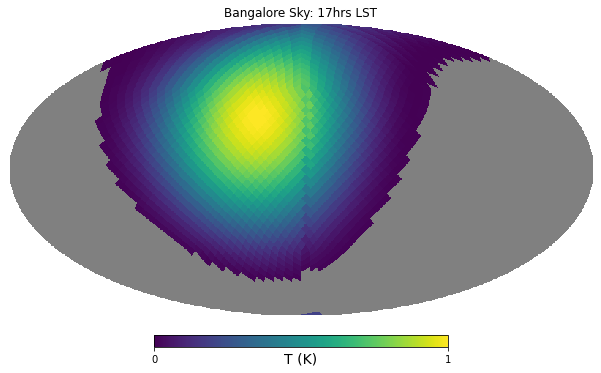

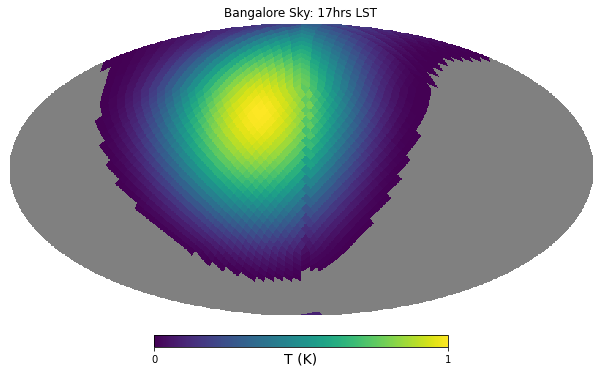

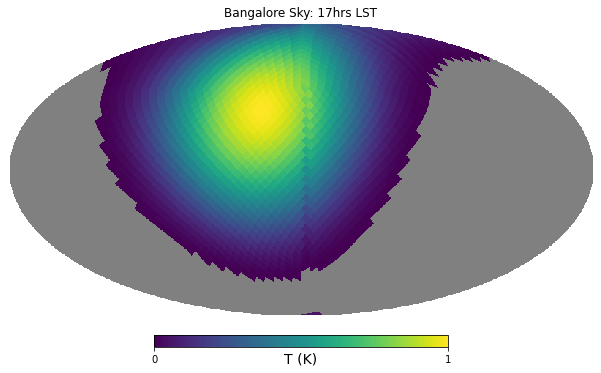

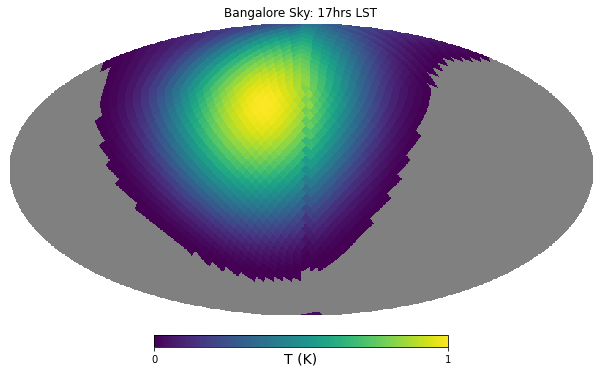

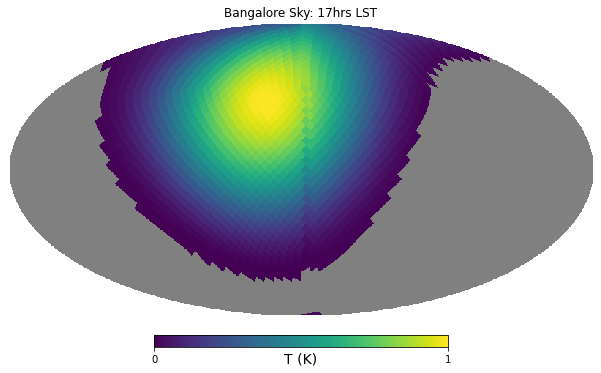

In [9]:
alpha_array = np.zeros((3072, 21))
gsm = GlobalSkyModel(freq_unit='GHz')

%matplotlib inline

for frequency in np.arange(2.0, 4.05, 0.5):
    
    T = ts[0]
    frequency = round(frequency, 2)
    print(f"Working for frequency: {frequency} GHz")
    def beam_def(freq, alt, az):
        #return float(my_interpolating_function([freq, alt, az]))
        
#         if (az >= 180):
#             az = az - 180
#             alt = 180 - alt
        
        
        if (alt<0):
            return 0 

        else:
            #return (math.cos((alt-20*(freq - 3))*PI/180)*math.cos((alt-20*(freq - 3))*PI/180))
            #return (math.sin(alt*PI/180)*math.sin(alt*PI/180)) + (freq - 3)*0.25*(math.sin(2*alt*PI/180))*(math.sin(2*alt*PI/180)) 
            #return (1/np.max((np.sin((check_alt)*PI/180)*np.sin((check_alt)*PI/180)) * np.cos(0.5*(check_alt*PI/180 - ((freq - 2)/2)*PI))))*(np.sin((alt)*PI/180)*np.sin((alt)*PI/180)) * np.cos(0.5*(alt*PI/180 - ((freq - 2)/2)*PI))
            #return 2*(np.sin((alt)*PI/180)*np.sin((alt)*PI/180)) * np.sin(az*PI/180) *np.cos(0.4*(az)*PI/180)
            #return (math.sin((alt - math.sin(az * PI/180)* 5 * (3 - freq)) * PI/180))**2
            
            alt1 = np.arccos(np.sin(alt * PI/180) * np.sin(az * PI/180) * np.sin(5*(freq - 3)*PI/180) + np.cos(alt * PI/180) * np.cos(5*(freq - 3)*PI/180))
            return (np.sin(alt1))**2
            
            # Correct 1d stretch:  return (math.sin(alt*PI/180)*math.sin(alt*PI/180)) + (freq - 3)*0.12*(math.sin(2*alt*PI/180))*(math.sin(2*alt*PI/180)) 

        
        
    #Refraction correction formula
    def refraction(alt_in_deg, altitude):
        pres = 1010.*math.pow((1-6.5/288000*altitude),5.255)
        if (altitude>11000):
            temp = 211.5
        else:
            temp = 283.0 - (alpha * altitude)
        R = 1.02/math.tan((alt_in_deg + (10.3/(alt_in_deg + 5.11)))*(PI/180))
        if (alt_in_deg == 90):
            R = R+ 0.0019279
        tpcor = (pres/1000) * (283/temp)
        R =  tpcor*(R/60)
        return alt_in_deg +R
    
    

    spectrum = gsm.generate(frequency)
    spectrum = hp.pixelfunc.ud_grade(spectrum, 16)                      #Reducing the resolution to NSIDE=16

    i=1

    while i<NPIX:           #Working on each pixel
        if (i%1000 == 0): print(i)
        coords = hp.pixelfunc.pix2ang(16, i , nest = False, lonlat = True)          #Gives l and b coordinates for each pixel
        gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below
        equi = gc.transform_to(AltAz(obstime = T, location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg, height=altitude*u.m)))
        
        alt = equi.alt.value
        if (i%1000 == 0): 
            print(alt)
        new_alt = refraction(equi.alt.value, altitude)

        longitudes = equi.az.value

        cwt = beam_def(frequency, new_alt, longitudes)

        #Using power law relation to fit spectra of three frequency maps
        def func(xx, a):
            return (sky_408)[i-1] * np.power((xx/0.408), a) 

        xx = np.array([0.408, 1.420, 23])
        yy = np.array([sky_408[i-1], sky_1420[i-1], sky_23000[i-1]])

        popt, pcov = curve_fit(func, xx, yy)
        

        spectrum[i-1] = sky_408[i-1]* np.power(frequency/0.408, float(popt))
        spectrum[i-1] = cwt


    
# #         #spectrum[i-1] = spectrum[i-1] 
        if (alt<=0):
            spectrum[i-1] = -1.6375e+30
            
#         if round(longitudes) == 180:
#             spectrum[i-1] = -1.6375e+30
        
#         if cwt > 0.98:
#             spectrum[i-1] = -1.6375e+30
        
        i = i+1
        
    vals_greater_qu_max = (spectrum > np.max(spectrum)/4).sum()
    sum_ = np.sum(spectrum[spectrum > 0])
    # print(f"Sum = {sum_}")

    hp.mollview(spectrum, title = f"Bangalore Sky: 17hrs LST",unit=r'T (K)', nest = False, min = 0, max = 1)
    #plt.savefig(f"Paper_files_and_data/1d_wobble/Corrected_beam_20degwobble/{frequency}GHz.png")
    
#     if frequency == 2.0:
#         global spectrum_to_divide
#         spectrum_to_divide = spectrum
#         alpha = np.ones(len(spectrum))
#     else: 
#         global alpha1
#         alpha1 = np.log(spectrum / spectrum_to_divide)/ np.log(frequency/ 2.0)
#         alpha = np.log(spectrum / spectrum_to_divide)/ np.log(frequency/ 2.0)
        
        
    
#     alpha_array[:, int(frequency*10 - 20)] = alpha
        
        
#         # If alt<0 in horizontal coordinates, that is not visible for the observer. So, suxh pixels are given minimum value (grey in map)
#         if (new_alt<0):
#             spectrum[i-1] = -1.6375e+30
#         else: 
#             spectrum_weighted_added = spectrum_weighted_added + spectrum[i-1]
        
    
  


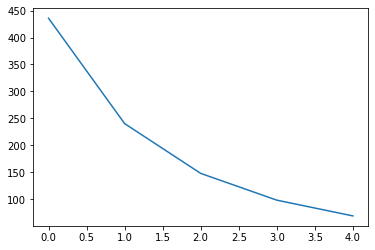

In [17]:
#hp.mollview(sky_1420, nest = False, norm='%hist')

plt.plot([435.82037197306227, 240.01657283487373, 147.50409288534308, 97.76887930332148, 68.48717009761587])
plt.show()

<IPython.core.display.Javascript object>


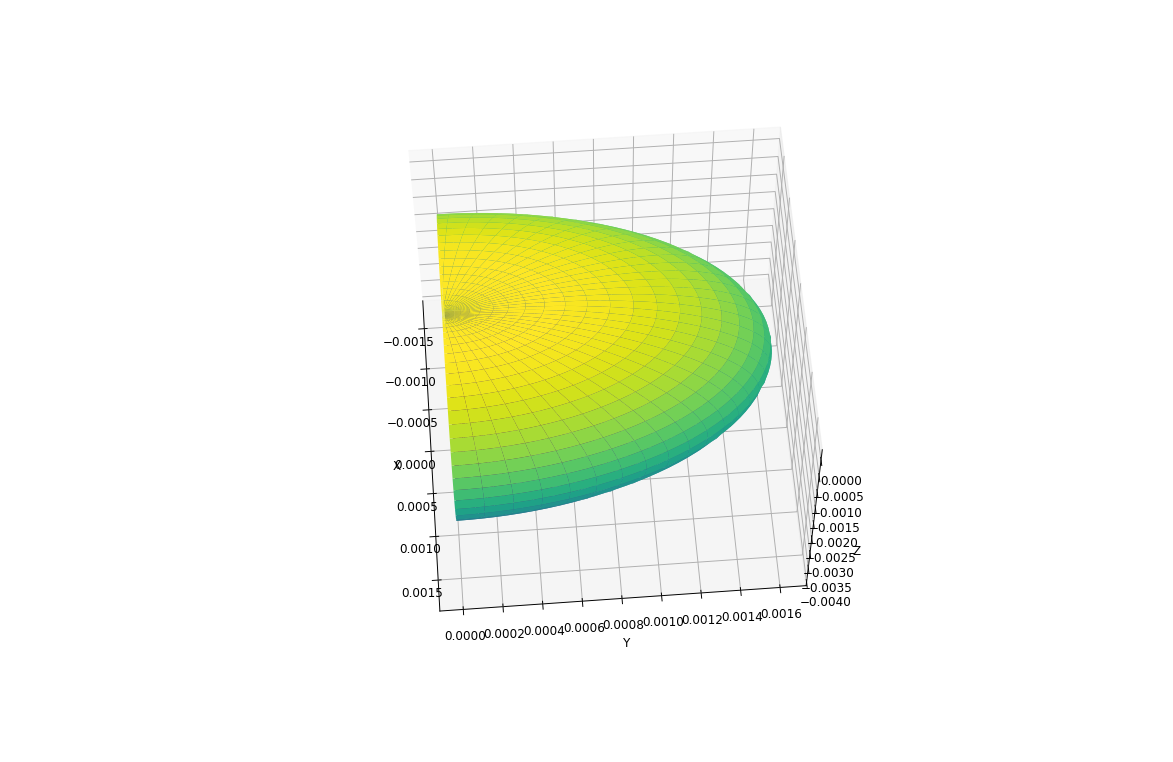

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

def beam_def(freq, alt, az):
    #return float(my_interpolating_function([freq, alt, az]))

#     if az < 180:
#         alt = 180 - alt 

    if (alt<0):
        return 0       
    else:
        #return (math.sin((alt-0*(freq - 3))*PI/180)*math.sin((alt-0*(freq - 3))*PI/180))
        return (1/np.max((np.sin((check_alt)*PI/180)*np.sin((check_alt)*PI/180)) * np.cos(0.5*(check_alt*PI/180 - ((freq - 2)/2)*PI))))*(np.sin((alt)*PI/180)*np.sin((alt)*PI/180)) * np.cos(0.5*(alt*PI/180 - ((freq - 2)/2)*PI))


# Create a grid of altitude and azimuthal values
altitude_values = np.linspace(0, np.pi, 72)  # Altitude values range from 0 to pi
azimuthal_values = np.linspace(0, np.pi, 72)  # Azimuthal values range from 0 to 2*pi
altitude_grid, azimuthal_grid = np.meshgrid(altitude_values, azimuthal_values)

# Calculate the function values for each point in the grid
radius_values2 = np.empty_like(altitude_grid)
for i in range(altitude_grid.shape[0]):
    for j in range(azimuthal_grid.shape[1]):
        radius_values2[i, j] = beam_def(2, altitude_grid[i, j], azimuthal_grid[i, j])

# Convert spherical coordinates to Cartesian coordinates for plotting
x_values = radius_values2 * np.sin(altitude_grid) * np.cos(azimuthal_grid)
y_values = radius_values2 * np.sin(altitude_grid) * np.sin(azimuthal_grid)
z_values2 = radius_values2 * np.cos(altitude_grid)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


#fig.colorbar(surf1, shrink=0.5, aspect=5)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

surf1 = ax.plot_surface(x_values, y_values, z_values2, cmap='viridis', alpha = 1)


# Show the plot
plt.show()


0.0
[0]


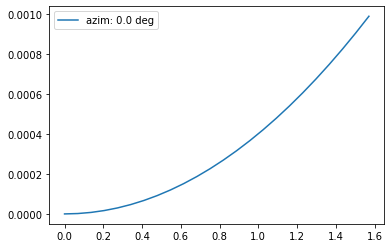

0.2731819698773733
[0]


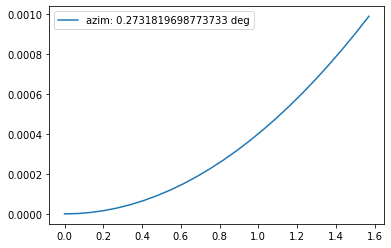

0.5463639397547466
[0]


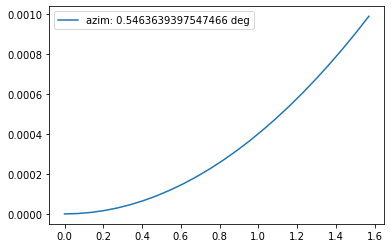

0.8195459096321199
[0]


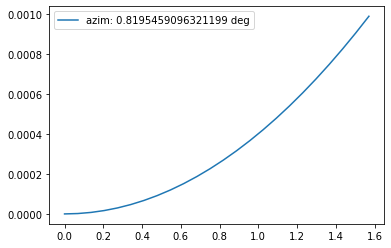

1.0927278795094932
[0]


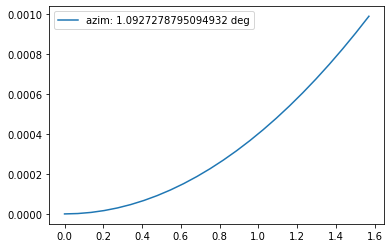

1.3659098493868664
[0]


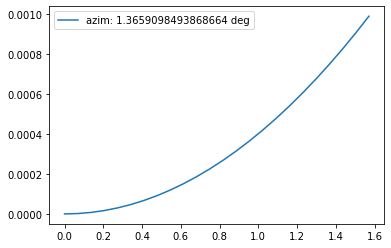

1.6390918192642399
[0]


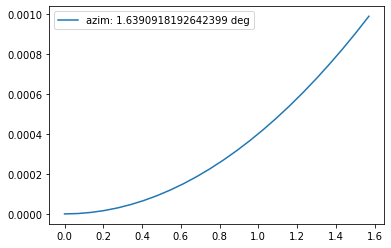

1.9122737891416133
[0]


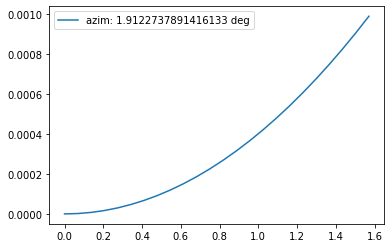

2.1854557590189865
[0]


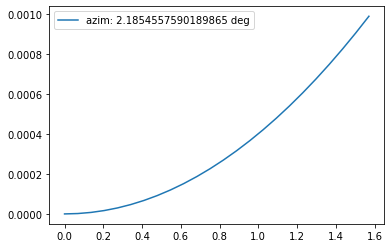

2.4586377288963597
[0]


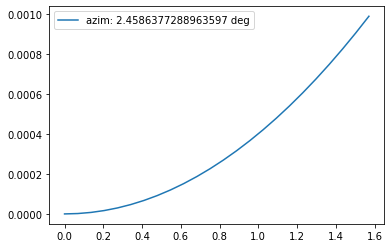

2.731819698773733
[0]


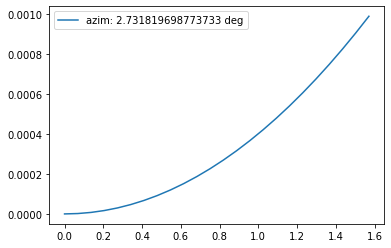

3.0050016686511065
[0]


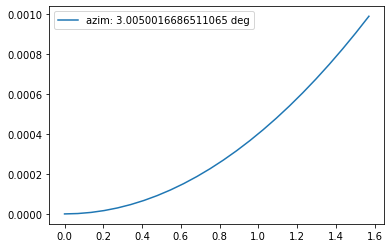

3.2781836385284797
[0]


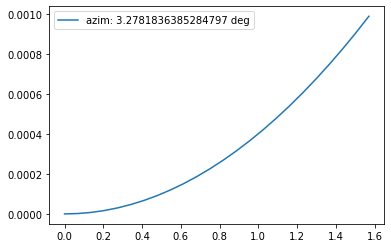

3.551365608405853
[0]


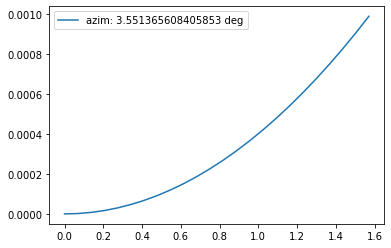

3.8245475782832266
[0]


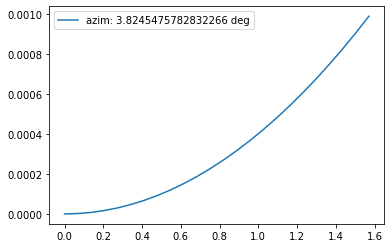

4.0977295481606
[0]


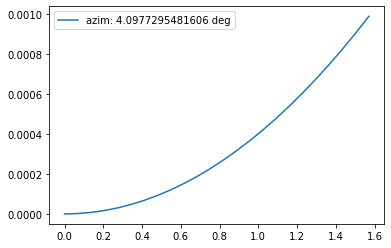

4.370911518037973
[0]


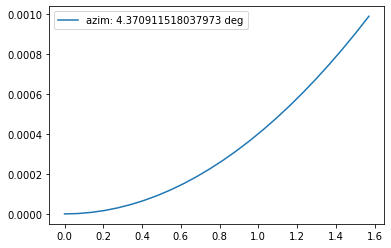

4.644093487915346
[0]


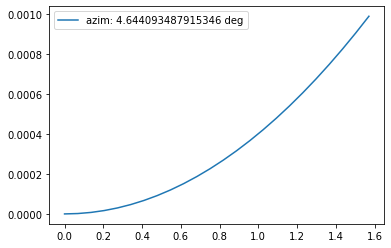

4.917275457792719
[0]


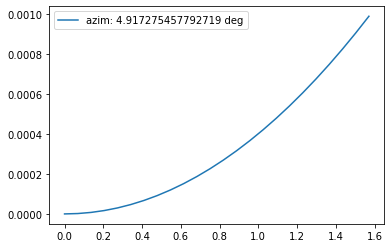

5.1904574276700925
[0]


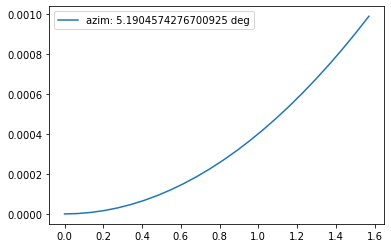

5.463639397547466
[0]


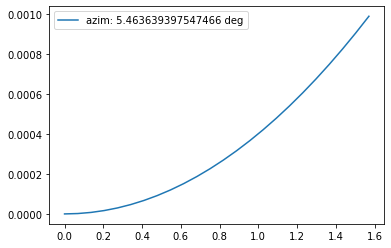

5.73682136742484
[0]


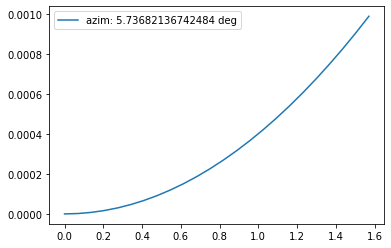

6.010003337302213
[0]


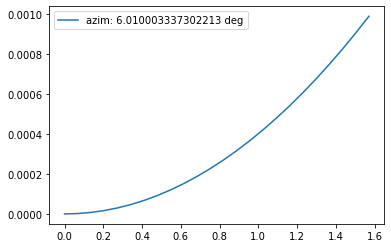

6.283185307179586
[0]


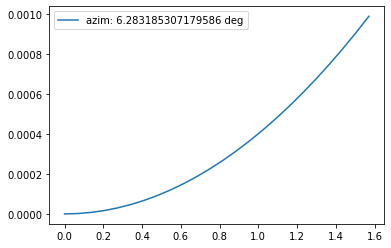

In [60]:
for azim in np.linspace(0, 2*np.pi, 24):
    print(azim)
    beam_weight = []
    for alti in np.linspace(0, np.pi/2, 24):
#         if azim > np.pi:
#             alti = np.pi - alti
        
        if alti <= 0:
            beam_weight.append(0)
            print(beam_weight)
        else:
            beam_weight.append((1/np.max((np.sin((check_alt)*PI/180)*np.sin((check_alt)*PI/180)) * np.cos(0.48*(check_alt*PI/180 - ((2 - 2)/2)*PI))))*(np.sin((alti)*PI/180)*np.sin((alti)*PI/180)) * np.cos(0.48*(alti*PI/180 - ((2 - 2)/2)*PI)))
        
    plt.plot(np.linspace(0, np.pi/2, 24), beam_weight, label = f'azim: {azim} deg')
    plt.legend()
    plt.show()
    
plt.show()
    

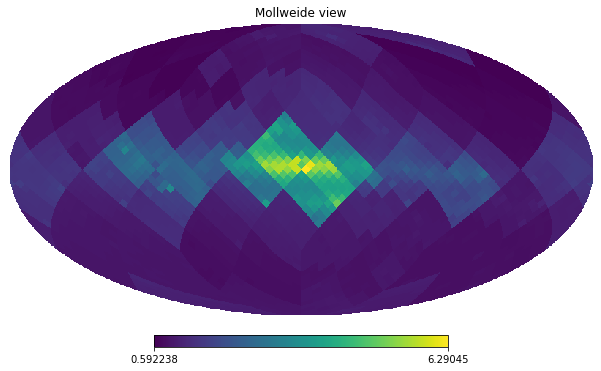

In [19]:
hp.mollview(hp.ud_grade(np.loadtxt('1420MHz_Sky_map.txt') - TCMB, 16), nest = True)

## <div align="center"><b> Getting maps, calculating CMB intensity </b></div>

In [12]:
gsm = GlobalSkyModel(freq_unit='GHz')

CMB_Int = ((2*h*1e+27*freqs**3)/(c*c))/(np.exp((h*freqs*1e+9)/(k*TCMB))-1)
print("Got CMB Int!")

#P_hot and P_cold for calibration
P_hot = (2*h*freqs*1e9)/(np.exp((h*freqs*1e9)/(k*T_hot))-1)
P_cold = (2*h*freqs*1e9)/(np.exp((h*freqs*1e9)/(k*T_cold))-1)
P_dif = P_hot -P_cold

print("Got P_dif for calibration!")

sky_1420 = hp.ud_grade(np.loadtxt('1420MHz_Sky_map.txt') - TCMB, 64, order_in = "NESTED", order_out= "RING")

sky_408 = hp.ud_grade(((np.loadtxt('408MHz_Sky_map.txt'))/1000) - TCMB, 64, order_in = "NESTED", order_out= "RING")
#sky_408 = ((np.loadtxt('408MHz_Sky_map.txt'))/1000) - TCMB
print(len(sky_408))

sky_23000 = hp.ud_grade((np.loadtxt('23000MHz_Sky_map.txt')/1000), 64, order_in = "NESTED", order_out= "RING")

print("Got 408MHz, 1420MHz and 23000MHz maps for power law fitting!")

Got CMB Int!
Got P_dif for calibration!
49152
Got 408MHz, 1420MHz and 23000MHz maps for power law fitting!


## <div align="center"><b> Getting recombination lines </b></div>


/tmp/ipykernel_5979/115827261.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(r'total_spec_new.txt',sep= "    " ,header = None)


<IPython.core.display.Javascript object>


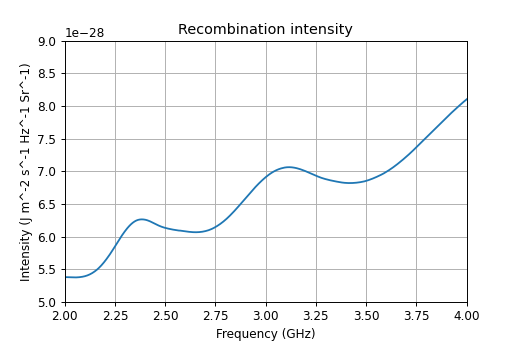

In [13]:
%matplotlib notebook
#/home/dhashin/workspace/APSERa/

df = pd.read_csv(r'total_spec_new.txt',sep= "    " ,header = None)
df.reset_index(drop=True, inplace=True)
df.columns = ["Frequency","Intensity"]

x = df["Frequency"]
y= df["Intensity"]

plt.plot((df['Frequency']), (df['Intensity']))
plt.title('Recombination intensity')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Intensity (J m^-2 s^-1 Hz^-1 Sr^-1)')
plt.xlim([f_start,f_stop])
plt.ylim([0.5e-27,0.9e-27])
plt.grid()
plt.show()

ius = InterpolatedUnivariateSpline(x, y)
Rec_int = ius(freqs)



<IPython.core.display.Javascript object>


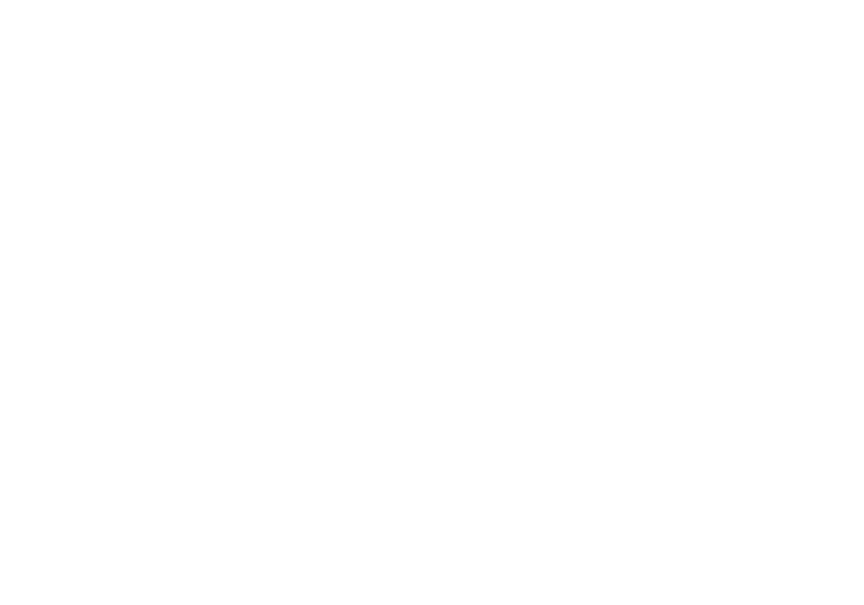

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def ant_reso_S11(freq, freq_dip, amp ,width ,start_dB,end_dB):
    result = np.zeros(np.shape(freq))
    i=0
    while(i<len(freq)):
        result[i] = start_dB + ((end_dB)/2)*(freq[i] - 2)
        j = 0
        while(j<len(freq_dip)):
            result[i] = result[i] - (amp[j]*width[j]**2/((freq[i]-freq_dip[j])**2+width[j]**2))
            j = j+1
        i = i +1
    result = result + 0.0005*np.sin(30*freq)#*np.cos(50*freq)*np.cos(50*freq)   
    return(np.array(result))
    
    
    
f_start = 2.0
f_stop = 4.0
No_of_Channels = 201
Channel_width = 0.01
freqs = np.linspace(f_start,f_stop, No_of_Channels)

freq_dip = np.array([3.5,2.75])
amp = np.array([0,0])
width = np.array([0.03,0.02])
start_dB = -10
end_dB = 0
            
plt.style.use('fast')
plt.figure(figsize=(10,7))        
plt.plot(freqs, ant_reso_S11(freqs, freq_dip, amp, width, start_dB,end_dB),linewidth=2.5, color = 'red')
plt.ylabel('Model S11 (dB)', fontsize='xx-large', fontweight='bold')
plt.xlabel('Frequency (GHz)', fontsize='xx-large', fontweight='bold')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim([-9.99,-10.01])
plt.xlim([2,4])
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

plt.plot(freqs, 1*np.sin(50*freqs))#*np.cos(50*freqs)*np.cos(50*freqs))
plt.vlines(2.75, ymax= 0.000001, ymin = -0.000001)
plt.show()
        
        
    
ga = np.power((1/20)*ant_reso_S11(freqs, freq_dip, amp, width, start_dB,end_dB), 10)

plt.plot(1-np.power(ga,2))
#plt.plot(ga)
plt.show()


## <div align="center"><b> Getting spectra </b></div>


Working for wob_1d: 0.0 and stretch: 0
31.85400846787613
Number of pixels got:  1000
52.8756420830123
Number of pixels got:  2000
44.43373219217225
Number of pixels got:  3000
47.422522488558656
Number of pixels got:  4000
-1.8300533082889285
Number of pixels got:  5000
37.391067133164924
Number of pixels got:  6000
-10.412338265070506
Number of pixels got:  7000
0.06561540781915531
Number of pixels got:  8000
-16.94448140984782
Number of pixels got:  9000
-22.68417127619898
Number of pixels got:  10000
-14.020965594386507
Number of pixels got:  11000
5.732636807234657
Number of pixels got:  12000
30.941615270719883
Number of pixels got:  13000
58.83695617234723
Number of pixels got:  14000
82.33251329615253
Number of pixels got:  15000
58.9567744389957
Number of pixels got:  16000
29.768942100583782
Number of pixels got:  17000
0.49762883749516734
Number of pixels got:  18000
-27.370174308644902
Number of pixels got:  19000
-47.0522469311354
Number of pixels got:  20000
-46.5875126211

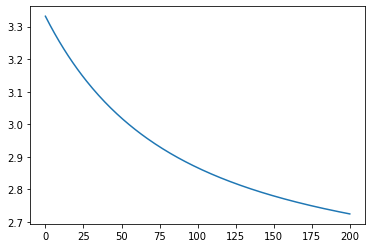

No. of spectra got =  1


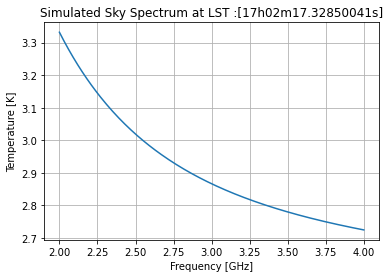

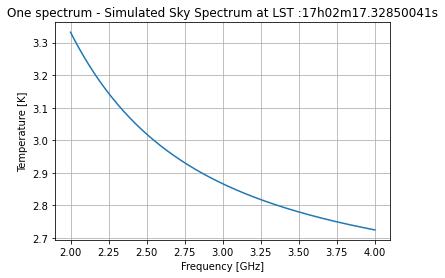

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201


/tmp/ipykernel_5979/1678384038.py:499: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq1, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq1 =  7.364893969796362e-05
2.7207644851885613 -0.18132055729527502 -2.734157331564924
 


/tmp/ipykernel_5979/1678384038.py:509: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq2, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq2 =  7.470834194835926e-06
2.724117172817176 -0.1836979326562549 -2.7401305136169607 -0.11179726670839697
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 415
         Function evaluations: 816
 
chisq3 =  4.43023526661424e-07
2.7265465148459733 -0.18529365984507018 -2.7518040141962707 -0.1202803293641451 -0.19043538368698826
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 890
         Function evaluations: 1560
 
chisq4 =  1.172096517146594e-08
2.727688806625318 -0.18605541487685323 -2.756489431017406 -0.13940882101184682 -0.19148477237131079 -0.17095929518277897
 


/tmp/ipykernel_5979/1678384038.py:539: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq5, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq5 =  7.923071841952469e-09
2.7278874300448868 -0.18618779405244043 -2.757333760296439 -0.14197151993885254 -0.19954401456914841 -0.16827266782335398 -0.04820950966683358
 


/tmp/ipykernel_5979/1678384038.py:549: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq6, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq6 =  7.920989949893649e-09
2.727887669355353 -0.18618795391738138 -2.7573347410159164 -0.14197529418403398 -0.19955238376230341 -0.16822988513543213 -0.04851765887314771 0.00041611845467263585
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 522
         Function evaluations: 1116
 
chisq7 =  7.9193735690427e-09
2.727887558348042 -0.18618787947525078 -2.7573343243140913 -0.141972419456811 -0.1995612889879275 -0.16818278669224207 -0.04854038984455172 0.00039988738970483245 -6.312419659662975e-05
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 503
         Function evaluations: 1091
 
chisq8 =  7.919295298970115e-09
2.727887572189953 -0.18618788881830867 -2.757334374566504 -0.14197273055630696 -0.19956126027579793 -0.1681823486567449 -0.0485509972018026 0.0004178976021973822 -8.268564667458505e-05 -4.3721801179099496e-11
Optimization terminated successfully.
         Curren

/tmp/ipykernel_5979/1678384038.py:583: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq10, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq10 =  7.91926510856879e-09
2.727887572110117 -0.18618788875396253 -2.75733437436379 -0.1419727371083917 -0.19956115930557386 -0.16818255467643653 -0.04855192304739757 0.00042073814611524955 -8.29662951935656e-05 -4.357453161961447e-11 5.623027695848324e-13 -1.7336036867570434e-13
 
[]


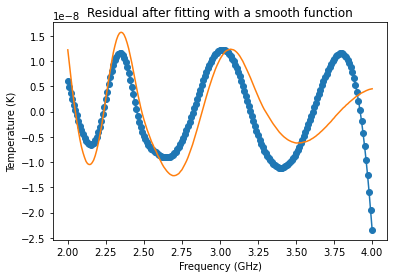

Euclidean distance: 9.09023429947618e-08 units
Working for wob_1d: 0.3 and stretch: 0
31.854008467840522
Number of pixels got:  1000
52.875642082986275
Number of pixels got:  2000
44.433732192143914
Number of pixels got:  3000
47.42252248853131
Number of pixels got:  4000
-1.8300533090097704
Number of pixels got:  5000
37.391067133133284
Number of pixels got:  6000
-10.412338264985657
Number of pixels got:  7000
0.06561540723561676
Number of pixels got:  8000
-16.944481409788047
Number of pixels got:  9000
-22.684171276152206
Number of pixels got:  10000
-14.02096559431691
Number of pixels got:  11000
5.732636807077142
Number of pixels got:  12000
30.941615270683457
Number of pixels got:  13000
58.83695617232207
Number of pixels got:  14000
82.33251329612624
Number of pixels got:  15000
58.95677443897055
Number of pixels got:  16000
29.768942100546226
Number of pixels got:  17000
0.4976288369936707
Number of pixels got:  18000
-27.370174308604867
Number of pixels got:  19000
-47.052246

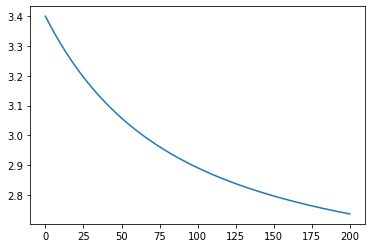

No. of spectra got =  1


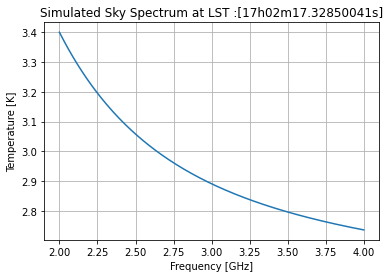

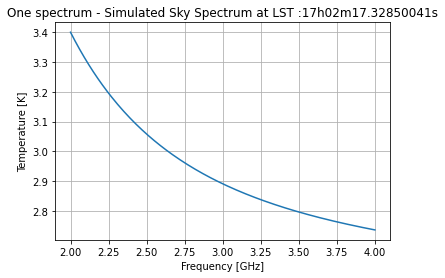

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  5.2738378641380384e-05
2.720894939316539 -0.13907855220054538 -2.7062725000286028
 
 
chisq2 =  7.012151508169192e-06
2.723392232672891 -0.14067911863877275 -2.7104533538275595 -0.07270882737952297
 
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 423
         Function evaluations: 828
 
chisq3 =  5.698473218760024e-07
2.725877455385933 -0.1421587794289793 -2.721045873665977 -0.08172392288456182 -0.16412133203351276
 


/tmp/ipykernel_5979/1678384038.py:529: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq4, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq4 =  3.3663999478998454e-08
2.727513760032657 -0.14314691303967547 -2.727075276909282 -0.10552505700441427 -0.1681249144463675 -0.20146812825554217
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1792
         Function evaluations: 2890
 
chisq5 =  6.327765716392977e-09
2.7283215995878183 -0.14363487726945756 -2.730154814914794 -0.11477244671961244 -0.19642626916816264 -0.19280863218089833 -0.16459918362625453
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 347
         Function evaluations: 788
 
chisq6 =  6.327755808110962e-09
2.7283216057950352 -0.1436348810053431 -2.7301548391801163 -0.11477252393851034 -0.1964262939196058 -0.19280962506128818 -0.16459932012092704 1.8702600317763212e-06
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 472
         Function evaluations: 1054
 
chisq7 =  6.327315518777142e-09
2.7283

/tmp/ipykernel_5979/1678384038.py:569: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq8, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq8 =  6.326552516605833e-09
2.7283214595384138 -0.14363479265406381 -2.730154281885992 -0.1147706033770489 -0.19642645792295005 -0.19277063526581095 -0.1646810245393917 1.325512508489275e-06 0.00034665604020804033 -0.00014389227863975996


/tmp/ipykernel_5979/1678384038.py:576: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq9, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq9 =  6.326544406752212e-09
2.7283214590116107 -0.14363479232827242 -2.7301542806276444 -0.114770592023139 -0.19642643078611832 -0.19277067958470434 -0.16468118200242005 1.3334499868773646e-06 0.0003487207309249708 -0.00014389227874865416 -2.7050259588177533e-12
 
chisq10 =  6.326544331674703e-09
2.7283214590116107 -0.14363479232827242 -2.7301542806276444 -0.114770592023139 -0.1964264308181322 -0.19277067969249348 -0.16468118274231672 1.3426798503698671e-06 0.0003487207976979889 -0.00014389227874865416 -2.7050259588177533e-12 0.0
 
[]


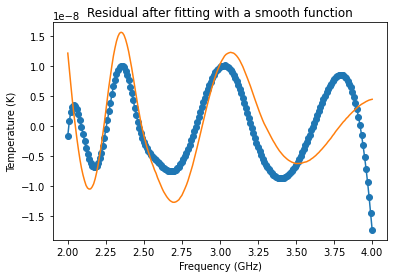

Euclidean distance: 7.903068413375851e-08 units
Working for wob_1d: 0.6 and stretch: 0
31.854008467840522
Number of pixels got:  1000
52.875642082986275
Number of pixels got:  2000
44.433732192143914
Number of pixels got:  3000


KeyboardInterrupt: 

In [16]:
%matplotlib inline

eucl_dis_wob1d_stretch = np.zeros((34, 6)) 


wob_1d = 0.0
stretch = 0


# def beam_def(freq, alt, az):
#     return (math.sin((alt-wob_1d*(freq - 3))*PI/180)*math.sin((alt-wob_1d*(freq - 3))*PI/180)) + stretch*(math.sin(2*alt*PI/180))*(math.sin(2*alt*PI/180))




while round(stretch,2) <= 0.0:
    while round(wob_1d,2) <= 10.0:
        
        #ga = np.power((1/20)*ant_reso_S11(freqs, freq_dip, amp, width, start_dB,end_dB), 10)

        
        print(f"Working for wob_1d: {wob_1d} and stretch: {stretch}")

        def beam_def(freq, alt, az):

            if (alt <= 0): 
                return 0
            else:
                #return (math.sin((alt-wob_1d*(freq - 3))*PI/180)*math.sin((alt-wob_1d*(freq - 3))*PI/180)) + stretch*(math.sin(2*alt*PI/180))*(math.sin(2*alt*PI/180))
                #return (1/np.max((np.sin((check_alt)*PI/180)*np.sin((check_alt)*PI/180)) * np.cos(wob_1d*(check_alt*PI/180 - ((freq - 2)/2)*PI))))*(np.sin((alt)*PI/180)*np.sin((alt)*PI/180)) * np.cos(wob_1d*(alt*PI/180 - ((freq - 2)/2)*PI))
                
                #return (math.sin((alt - math.sin(az * PI/180)* wob_1d * (3 - freq)) * PI/180))**2
                alt1 = np.arccos(np.sin(alt * PI/180) * np.sin(az * PI/180) * np.sin(4.8*(freq - 3)*PI/180) + np.cos(alt * PI/180) * np.cos(4.8*(freq - 3)*PI/180))
                return (np.sin(alt1))**2                


        t = 0
        while t<n_spectra:
            i=1
            while i<NPIX:           #Working on each pixel
                
                coords = hp.pixelfunc.pix2ang(64, i , nest = False, lonlat = True)          #Gives l and b coordinates for each pixel
                gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')

                #Now, the coordinates in Galactic frame is changed to equitorial frame below
                equi = gc.transform_to(AltAz(obstime = ts[0], location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg , height=altitude*u.m)))
                alt = equi.alt.value
                new_alt = refraction(alt, altitude) 
                if (i%1000 == 0): print(new_alt)

                #Using power law relation to fit spectra of three frequency maps
                def func(xx, a):
                    return (sky_408)[i-1] * np.power((xx/0.408), a) 

                xx = np.array([0.408, 1.420, 23])
                yy = np.array([sky_408[i-1], sky_1420[i-1], sky_23000[i-1]])

                popt, pcov = curve_fit(func, xx, yy)


                j=0
                longitudes = equi.az.value
                while j< No_of_Channels:


                    cwt = beam_def(freqs[j], new_alt, longitudes)


                    if (cwt>0):     #Adding all the three intensities

                        map_1 = (2*k*1e+18 * (freqs[j]**2) *sky_408[i-1]* np.power(freqs[j]/0.408, float(popt)))/ (c**2)

                        Power = (CMB_Int[j]+ map_1+Rec_int[j]) *(c*c/ (1e+18* freqs[j]**2)) #+Rec_int[j] + map_1 + CMB_Int[j] 
                        #final_temp = (Power/P_dif[j])*(T_hot-T_cold)
                        cross_real[j] = cross_real[j] + cwt*Power # *(1 - math.pow(ga[j],2))            #*(1-(gamma_func(freqs[j]))**2)    
                        #Uncomment the above 1-gamma^2 term if you are using the real antenna beam

                        sumwt[j] = sumwt[j]+ cwt

                        final_temp[j] = (cross_real[j]/P_dif[j])*(T_hot-T_cold)

                    j = j+1

                if (i%1000 == 0):
                    print('Number of pixels got: ', i)

                i = i+1


            i=0    
            while(i< No_of_Channels):
                if sumwt[i]>0:
                    final_temp[i] = final_temp[i]/sumwt[i]
                i = i+1
            
            plt.plot(final_temp)
            plt.title("")
            plt.show()


            cross_real = final_temp
            sigma = (np.array(cross_real) + Trx+ T_atm)/ math.sqrt(Channel_width*1e9*Noise_int_time)    

            #Generating an array of random integers with mean 0 and std 1. 
            array = np.random.normal(0,1,No_of_Channels)

            #Adding the gaussian error
            #cross_real = cross_real + array*sigma         #Comment out this line if you need spectra without noise
            cross_imag = cross_imag + array*sigma

            spectra[t] = cross_real
            spectra_cross_imag[t] = cross_imag

            cross_real = [0]*No_of_Channels
            cross_imag = [0]*No_of_Channels
            sumwt = [0]*No_of_Channels
            sigma = [0]*No_of_Channels

            print("No. of spectra got = ", t+1)

            t = t+1

        Obs = ephem.Observer()
        t = Time(Time_in_UTC, scale='utc',location=(longitude, latitude))
        lst = t.sidereal_time('apparent')


        i=0
        while(i<n_spectra):
            plt.plot(freqs, spectra[i])
            i=i+1

        plt.xlabel('Frequency [GHz]')
        plt.ylabel('Temperature [K]')
        plt.title('Simulated Sky Spectrum at LST :%s'%lst)
        plt.grid()
        plt.show()

        plt.plot(freqs, spectra[0])
        plt.xlabel('Frequency [GHz]')
        plt.ylabel('Temperature [K]')
        plt.title('One spectrum - Simulated Sky Spectrum at LST :%s'%lst[0])
        plt.grid()
        plt.show()
        
        #hp.mollview(check_map, nest = True)


        import numpy as np
        import matplotlib.pyplot as plt
        import scipy.constants
        import random as rndm
        from math import exp, expm1, sqrt
        from math import factorial as mf
        from scipy.optimize import fmin
        from scipy import interpolate
        from matplotlib.backends.backend_pdf import PdfPages

        PI=scipy.constants.pi
        HH=scipy.constants.h
        KK=scipy.constants.k
        HbK=HH/KK
        HbK9=HbK*1.0e9

        X1 = 2.0
        X2 = 4.0
        print (' ')
        print ('CAUTION: this version is hard-coded for freq range: ',X1,' to ',X2,' GHz')

        X1LOG = np.log10(X1)
        X2LOG = np.log10(X2)
        XDIF = X1LOG-X2LOG

        np.set_printoptions(precision=20)
        
        
        func1 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                            10.0**( \
                            (p[1]) + \
                            (p[2])*(np.log10(x)-X1LOG)**1 \
                                  )

        func2 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                            10.0**( \
                            (p[1]) + \
                            (p[2])*(np.log10(x)-X1LOG)**1 + \
                            (p[3])*(np.log10(x)-X1LOG)**2  \
                                  )

        func3 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                            10.0**( \
                            (p[1]) + \
                            (p[2])*(np.log10(x)-X1LOG)**1 + \
                            (p[3])*(np.log10(x)-X1LOG)**2 + \
                            (p[4])*(np.log10(x)-X1LOG)**3  \
                                  )

        func4 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                            10.0**( \
                            (p[1]) + \
                            (p[2])*(np.log10(x)-X1LOG)**1 + \
                            (p[3])*(np.log10(x)-X1LOG)**2 + \
                            (p[4])*(np.log10(x)-X1LOG)**3 + \
                            (p[5])*(np.log10(x)-X1LOG)**4  \
                                  )

        func5 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                            10.0**( \
                            (p[1]) + \
                            (p[2])*(np.log10(x)-X1LOG)**1 + \
                            (p[3])*(np.log10(x)-X1LOG)**2 + \
                            (p[4])*(np.log10(x)-X1LOG)**3 + \
                            (p[5])*(np.log10(x)-X1LOG)**4 + \
                            (p[6])*(np.log10(x)-X1LOG)**5  \
                                  )

        func6 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                            10.0**( \
                            (p[1]) + \
                            (p[2])*(np.log10(x)-X1LOG)**1 + \
                            (p[3])*(np.log10(x)-X1LOG)**2 + \
                            (p[4])*(np.log10(x)-X1LOG)**3 + \
                            (p[5])*(np.log10(x)-X1LOG)**4 + \
                            (p[6])*(np.log10(x)-X1LOG)**5 + \
                            (p[7])*(np.log10(x)-X1LOG)**6  \
                                  )

        func7 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                            10.0**( \
                            (p[1]) + \
                            (p[2])*(np.log10(x)-X1LOG)**1 + \
                            (p[3])*(np.log10(x)-X1LOG)**2 + \
                            (p[4])*(np.log10(x)-X1LOG)**3 + \
                            (p[5])*(np.log10(x)-X1LOG)**4 + \
                            (p[6])*(np.log10(x)-X1LOG)**5 + \
                            (p[7])*(np.log10(x)-X1LOG)**6 + \
                            (p[8])*(np.log10(x)-X1LOG)**7  \
                                  )
        func8 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                            10.0**( \
                            (p[1]) + \
                            (p[2])*(np.log10(x)-X1LOG)**1 + \
                            (p[3])*(np.log10(x)-X1LOG)**2 + \
                            (p[4])*(np.log10(x)-X1LOG)**3 + \
                            (p[5])*(np.log10(x)-X1LOG)**4 + \
                            (p[6])*(np.log10(x)-X1LOG)**5 + \
                            (p[7])*(np.log10(x)-X1LOG)**6 + \
                            (p[8])*(np.log10(x)-X1LOG)**7 + \
                            (p[9])*(np.log10(x)-X1LOG)**8)

        func9 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                            10.0**( \
                            (p[1]) + \
                            (p[2])*(np.log10(x)-X1LOG)**1 + \
                            (p[3])*(np.log10(x)-X1LOG)**2 + \
                            (p[4])*(np.log10(x)-X1LOG)**3 + \
                            (p[5])*(np.log10(x)-X1LOG)**4 + \
                            (p[6])*(np.log10(x)-X1LOG)**5 + \
                            (p[7])*(np.log10(x)-X1LOG)**6 + \
                            (p[8])*(np.log10(x)-X1LOG)**7 + \
                            (p[9])*(np.log10(x)-X1LOG)**8 + \
                                (p[10])*(np.log10(x)-X1LOG)**9)

        func10 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                            10.0**( \
                            (p[1]) + \
                            (p[2])*(np.log10(x)-X1LOG)**1 + \
                            (p[3])*(np.log10(x)-X1LOG)**2 + \
                            (p[4])*(np.log10(x)-X1LOG)**3 + \
                            (p[5])*(np.log10(x)-X1LOG)**4 + \
                            (p[6])*(np.log10(x)-X1LOG)**5 + \
                            (p[7])*(np.log10(x)-X1LOG)**6 + \
                            (p[8])*(np.log10(x)-X1LOG)**7 + \
                            (p[9])*(np.log10(x)-X1LOG)**8 + \
                                (p[10])*(np.log10(x)-X1LOG)**9+ \
                            (p[11])*(np.log10(x)-X1LOG)**10)	

        func11 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                            10.0**( \
                            (p[1]) + \
                            (p[2])*(np.log10(x)-X1LOG)**1 + \
                            (p[3])*(np.log10(x)-X1LOG)**2 + \
                            (p[4])*(np.log10(x)-X1LOG)**3 + \
                            (p[5])*(np.log10(x)-X1LOG)**4 + \
                            (p[6])*(np.log10(x)-X1LOG)**5 + \
                            (p[7])*(np.log10(x)-X1LOG)**6 + \
                            (p[8])*(np.log10(x)-X1LOG)**7 + \
                            (p[9])*(np.log10(x)-X1LOG)**8 + \
                                (p[10])*(np.log10(x)-X1LOG)**9+ \
                            (p[11])*(np.log10(x)-X1LOG)**10+ \
                            (p[12])*(np.log10(x)-X1LOG)**11)

        func12 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                            10.0**( \
                            (p[1]) + \
                            (p[2])*(np.log10(x)-X1LOG)**1 + \
                            (p[3])*(np.log10(x)-X1LOG)**2 + \
                            (p[4])*(np.log10(x)-X1LOG)**3 + \
                            (p[5])*(np.log10(x)-X1LOG)**4 + \
                            (p[6])*(np.log10(x)-X1LOG)**5 + \
                            (p[7])*(np.log10(x)-X1LOG)**6 + \
                            (p[8])*(np.log10(x)-X1LOG)**7 + \
                            (p[9])*(np.log10(x)-X1LOG)**8 + \
                                (p[10])*(np.log10(x)-X1LOG)**9+ \
                            (p[11])*(np.log10(x)-X1LOG)**10+ \
                            (p[12])*(np.log10(x)-X1LOG)**11+ \
                            (p[13])*(np.log10(x)-X1LOG)**12)	

        # define the function to be minimized by scipy.optimize.fmin
        chisq1 = lambda p, x, y: sqrt(((func1(p,x)-y)**2).sum()/float(len(x)))

        chisq2 = lambda p, x, y: sqrt(((func2(p,x)-y)**2).sum()/float(len(x)))

        def chisq3 (p, x, y):
            k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG)
            for i in range (len(x)-1):
                if k2[i+1]*k2[i] < 0.0: 
                    return 100.0+min(i,len(x)-i)
            return sqrt(((func3(p,x)-y)**2).sum()/float(len(x)))

        def chisq4 (p, x, y ):
            k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
                (mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2
            k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG)
            for i in range (len(x)-1):
                if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0: 
                    return 100.0+min(i,len(x)-i)
            return sqrt(((func4(p,x)-y)**2).sum()/float(len(x)))

        def chisq5 (p, x, y ):
            k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
                (mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3
            k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
                (mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2
            k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG)
            for i in range (len(x)-1):
                if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0: 
                    return 100.0+min(i,len(x)-i)
            return sqrt(((func5(p,x)-y)**2).sum()/float(len(x)))

        def chisq6 (p, x, y ):
            k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
                (mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
                (mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4
            k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
                (mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3
            k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
                (mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2
            k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG)
            for i in range (len(x)-1):
                if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
                    or k5[i+1]*k5[i] < 0.0: 
                    return 100.0+min(i,len(x)-i)
            return sqrt(((func6(p,x)-y)**2).sum()/float(len(x)))

        def chisq7 (p, x, y):
            k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
                (mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
                (mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4 + (mf(7)/mf(5))*p[8]*(np.log10(x)-X1LOG)**5
            k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
                (mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3 + \
                (mf(7)/mf(4))*p[8]*(np.log10(x)-X1LOG)**4
            k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
                (mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2 + (mf(7)/mf(3))*p[8]*(np.log10(x)-X1LOG)**3
            k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG) + \
                (mf(7)/mf(2))*p[8]*(np.log10(x)-X1LOG)**2
            k6 = (mf(6)/mf(0))*p[7] + (mf(7)/mf(1))*p[8]*(np.log10(x)-X1LOG)
            for i in range (len(x)-1):
                if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
                    or k5[i+1]*k5[i] < 0.0 or k6[i+1]*k6[i] < 0.0: 
                    return 100.0+min(i,len(x)-i)
            return sqrt(((func7(p,x)-y)**2).sum()/float(len(x)))

        def chisq8 (p, x, y):
            k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
                (mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
                (mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4 + (mf(7)/mf(5))*p[8]*(np.log10(x)-X1LOG)**5 + \
                (mf(8)/mf(6))*p[9]*(np.log10(x)-X1LOG)**6
            k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
                (mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3 + \
                (mf(7)/mf(4))*p[8]*(np.log10(x)-X1LOG)**4 + (mf(8)/mf(5))*p[9]*(np.log10(x)-X1LOG)**5
            k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
                (mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2 + (mf(7)/mf(3))*p[8]*(np.log10(x)-X1LOG)**3 + \
                (mf(8)/mf(4))*p[9]*(np.log10(x)-X1LOG)**4
            k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG) + \
                (mf(7)/mf(2))*p[8]*(np.log10(x)-X1LOG)**2 + (mf(8)/mf(3))*p[9]*(np.log10(x)-X1LOG)**3
            k6 = (mf(6)/mf(0))*p[7] + (mf(7)/mf(1))*p[8]*(np.log10(x)-X1LOG) +  (mf(8)/mf(2))*p[9]*(np.log10(x)-X1LOG)**2
            k7 = (mf(7)/mf(0))*p[8] + (mf(8)/mf(1))*p[9]*(np.log10(x)-X1LOG)
            for i in range (len(x)-1):
                if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
                    or k5[i+1]*k5[i] < 0.0 or k6[i+1]*k6[i] < 0.0 or k7[i+1]*k7[i]< 0.0: 
                    return 100.0+min(i,len(x)-i)
            return sqrt(((func8(p,x)-y)**2).sum()/float(len(x)))

        def chisq9 (p, x, y):
            k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
                (mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
                (mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4 + (mf(7)/mf(5))*p[8]*(np.log10(x)-X1LOG)**5 + \
                (mf(8)/mf(6))*p[9]*(np.log10(x)-X1LOG)**6 + (mf(9)/mf(7))*p[10]*(np.log10(x)-X1LOG)**7
            k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
                (mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3 + \
                (mf(7)/mf(4))*p[8]*(np.log10(x)-X1LOG)**4 + (mf(8)/mf(5))*p[9]*(np.log10(x)-X1LOG)**5 + \
                (mf(9)/mf(6))*p[10]*(np.log10(x)-X1LOG)**6
            k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
                (mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2 + (mf(7)/mf(3))*p[8]*(np.log10(x)-X1LOG)**3 + \
                (mf(8)/mf(4))*p[9]*(np.log10(x)-X1LOG)**4 + (mf(9)/mf(5))*p[10]*(np.log10(x)-X1LOG)**5
            k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG) + \
                (mf(7)/mf(2))*p[8]*(np.log10(x)-X1LOG)**2 + (mf(8)/mf(3))*p[9]*(np.log10(x)-X1LOG)**3 + \
                (mf(9)/mf(4))*p[10]*(np.log10(x)-X1LOG)**4
            k6 = (mf(6)/mf(0))*p[7] + (mf(7)/mf(1))*p[8]*(np.log10(x)-X1LOG) + (mf(8)/mf(2))*p[9]*(np.log10(x)-X1LOG)**2 + \
                   (mf(9)/mf(3))*p[10]*(np.log10(x)-X1LOG)**3
            k7 = (mf(7)/mf(0))*p[8] + (mf(8)/mf(1))*p[9]*(np.log10(x)-X1LOG) + (mf(9)/mf(2))*p[10]*(np.log10(x)-X1LOG)**2
            k8 = (mf(8)/mf(0))*p[9] + (mf(9)/mf(1))*p[10]*(np.log10(x)-X1LOG)
            for i in range (len(x)-1):
                if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
                    or k5[i+1]*k5[i] < 0.0 or k6[i+1]*k6[i] < 0.0 or k7[i+1]*k7[i]< 0.0 \
                    or k8[i+1]*k8[i]< 0.0: 
                    return 100.0+min(i,len(x)-i)
            return sqrt(((func9(p,x)-y)**2).sum()/float(len(x)))

        def chisq10 (p, x, y):
            k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
                (mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
                (mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4 + (mf(7)/mf(5))*p[8]*(np.log10(x)-X1LOG)**5 + \
                (mf(8)/mf(6))*p[9]*(np.log10(x)-X1LOG)**6 + (mf(9)/mf(7))*p[10]*(np.log10(x)-X1LOG)**7 + \
                (mf(10)/mf(8))*p[11]*(np.log10(x)-X1LOG)**8
            k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
                (mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3 + \
                (mf(7)/mf(4))*p[8]*(np.log10(x)-X1LOG)**4 + (mf(8)/mf(5))*p[9]*(np.log10(x)-X1LOG)**5 + \
                (mf(9)/mf(6))*p[10]*(np.log10(x)-X1LOG)**6 + (mf(10)/mf(7))*p[11]*(np.log10(x)-X1LOG)**7
            k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
                (mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2 + (mf(7)/mf(3))*p[8]*(np.log10(x)-X1LOG)**3 + \
                (mf(8)/mf(4))*p[9]*(np.log10(x)-X1LOG)**4 + (mf(9)/mf(5))*p[10]*(np.log10(x)-X1LOG)**5 + \
                (mf(10)/mf(6))*p[11]*(np.log10(x)-X1LOG)**6
            k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG) + \
                (mf(7)/mf(2))*p[8]*(np.log10(x)-X1LOG)**2 + (mf(8)/mf(3))*p[9]*(np.log10(x)-X1LOG)**3 + \
                (mf(9)/mf(4))*p[10]*(np.log10(x)-X1LOG)**4 + (mf(10)/mf(5))*p[11]*(np.log10(x)-X1LOG)**5
            k6 = (mf(6)/mf(0))*p[7] + (mf(7)/mf(1))*p[8]*(np.log10(x)-X1LOG) + (mf(8)/mf(2))*p[9]*(np.log10(x)-X1LOG)**2 + \
                   (mf(9)/mf(3))*p[10]*(np.log10(x)-X1LOG)**3 + (mf(10)/mf(4))*p[11]*(np.log10(x)-X1LOG)**4
            k7 = (mf(7)/mf(0))*p[8] + (mf(8)/mf(1))*p[9]*(np.log10(x)-X1LOG) + (mf(9)/mf(2))*p[10]*(np.log10(x)-X1LOG)**2 + \
                (mf(10)/mf(3))*p[11]*(np.log10(x)-X1LOG)**3
            k8 = (mf(8)/mf(0))*p[9] + (mf(9)/mf(1))*p[10]*(np.log10(x)-X1LOG) + (mf(10)/mf(2))*p[11]*(np.log10(x)-X1LOG)**2
            k9 = (mf(9)/mf(0))*p[10] + (mf(10)/mf(1))*p[11]*(np.log10(x)-X1LOG)
            for i in range (len(x)-1):
                if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
                    or k5[i+1]*k5[i] < 0.0 or k6[i+1]*k6[i] < 0.0 or k7[i+1]*k7[i]< 0.0 \
                    or k8[i+1]*k8[i]< 0.0 or k9[i+1]*k9[i]< 0.0: 
                    return 100.0+min(i,len(x)-i)
            return sqrt(((func10(p,x)-y)**2).sum()/float(len(x)))
        

        
        residuals = []
        x0 = freqs
        #print(x0)
        x0 = np.asfarray(x0)
        x0log = np.log10(x0)


        low=1.0
        high=5.0


        i_low=0
        i_high=len(x0)
        for i in range(0, len(x0)):
            if x0[i]<=low:
                i_low=i
            if x0[i]<=high:
                i_high=i
        print("Limits in index: ",i_low,i_high)
        x1=x0[i_low:i_high+1]   #Check the +1 term
        x1log = np.log10(x1)
        X1=(x1log[0])
        print(x1.size)

        y1 = np.array(spectra[0])
        print(y1.size)
        y1log = np.log10(y1)
        

        
        p12 = np.poly1d(np.polyfit(x1log, y1log, 10))
        yfit_poly = p12(x1log)
        yres_poly = (10.0**yfit_poly) - y1
        #plt.figure()
        #plt.grid()
        #plt.xlabel('Freq [MHz]')
        #plt.ylabel('res Temp [K]')
        #plt.plot(x1*1.0e3,yres_poly,lw=2)
        #plt.plot(np.log10(nu),np.log10(T[pix]),'ro')
        #plt.title('Polyo10 residual spec %s'%(i))
        # plt.show()
        #pdf.savefig()
        #plt.close()
        # Initial guess for optimization				
        p00 = [np.log10(3.0),1.0,-2.5] 

        p1 = fmin(chisq1, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq1, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq1, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
        current_chisq = chisq1(p1,x1,y1)
        print (" ")
        print ("chisq1 = ",current_chisq)
        print (10.0**p1[0], p1[1], p1[2])
        print (" ")

        p00 = [p1[0],p1[1],p1[2],0.0] 
        p1 = fmin(chisq2, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq2, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq2, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
        final_chisq = chisq2(p1,x1,y1)
        print (" ")
        print ("chisq2 = ",final_chisq)
        print (10.0**p1[0], p1[1], p1[2], p1[3])
        print (" ")

        p00 = [p1[0],p1[1],p1[2],p1[3],0.0]
        p1 = fmin(chisq3, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq3, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq3, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
        final_chisq = chisq3(p1,x1,y1)
        print (" ")
        print ("chisq3 = ",final_chisq)
        print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4])
        print (" ")

        p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],0.0]
        p1 = fmin(chisq4, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq4, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq4, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
        final_chisq = chisq4(p1,x1,y1)
        print (" ")
        print ("chisq4 = ",final_chisq)
        print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5])
        print (" ")

        p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],0.0]
        p1 = fmin(chisq5, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq5, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq5, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
        final_chisq = chisq5(p1,x1,y1)
        print (" ")
        print ("chisq5 = ",final_chisq)
        print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6])
        print (" ")

        p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],0.0]
        p1 = fmin(chisq6, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq6, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq6, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
        final_chisq = chisq6(p1,x1,y1)
        print (" ")
        print ("chisq6 = ",final_chisq)
        print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7])
        print (" ")

        p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],0.0]
        p1 = fmin(chisq7, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq7, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq7, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
        final_chisq = chisq7(p1,x1,y1)
        print (" ")
        print ("chisq7 = ",final_chisq)
        print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8])
        print (" ")

        p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],p1[8],0.0]
        p1 = fmin(chisq8, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
        final_chisq = chisq8(p1,x1,y1)
        print (" ")
        print ("chisq8 = ",final_chisq)
        print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8], p1[9])

        p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],p1[8],p1[9],0.0]
        p1 = fmin(chisq9, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
        final_chisq = chisq9(p1,x1,y1)
        print (" ")
        print ("chisq9 = ",final_chisq)
        print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8], p1[9],p1[10])

        p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],p1[8],p1[9],p1[10],0.0]
        p1 = fmin(chisq10, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
        final_chisq = chisq10(p1,x1,y1)
        print (" ")
        print ("chisq10 = ",final_chisq)
        print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8], p1[9],p1[10],p1[11])
        print (" ")

        yfit = func10(p1,x1)
        yres = y1 - yfit
        #residuals.append(yres) 
        # scale = 0.03/chisq12(p1,x1,y1)
        # y2 = yfit + scale*(1.0e5**yres)
        yfitlog=np.log10(yfit)

        residuals = np.asfarray(residuals)
        print(residuals)

        sp1 = y1 -yfit

        plt.plot(freqs, sp1, marker = 'o')
        plt.plot(freqs, np.loadtxt("Final_Template Bank/P0_no_noise"))
        plt.ylabel('Temperature (K)')
        plt.xlabel('Frequency (GHz)')
        plt.title('Residual after fitting with a smooth function')
        

        
        #plt.savefig(f"Final_graphs/Dif_loc/wob_1d: {round(wob_1d, 2)} + stretch: {round(stretch, 2)}.png", dpi = 300)
        plt.show()
        
        euc_dis = scipy.spatial.distance.euclidean(sp1, np.loadtxt("Final_Template Bank/P0_no_noise")) 
        eucl_dis_wob1d_stretch[int(round(wob_1d/0.3, 0))][int(round(stretch/ 0.05, 0))] = euc_dis 
        
        
        print(f"Euclidean distance: {euc_dis} units")
        
        
        wob_1d = wob_1d + 0.3
    stretch = stretch + 0.05
    
    
    


In [15]:
print(NPIX)

49152


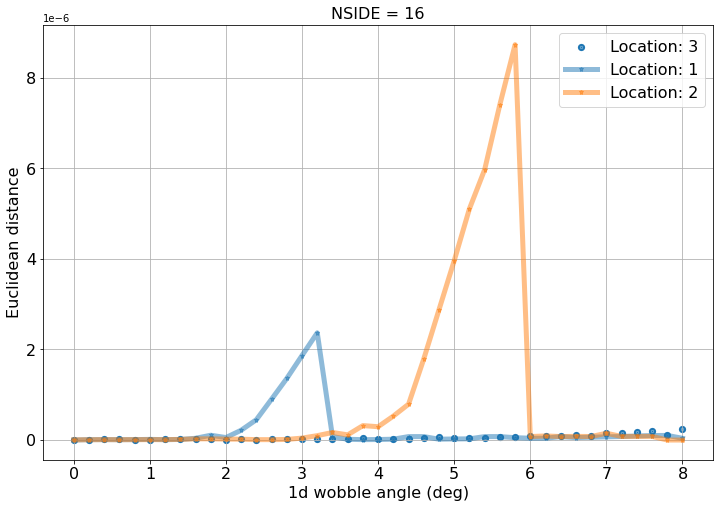

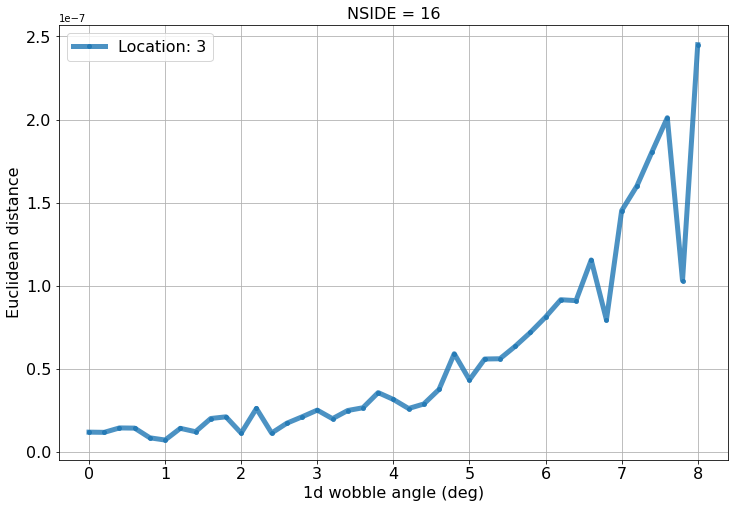

In [109]:
%matplotlib inline

np.savetxt("Final_graphs/Loc3_ED_Signal_1dwobble.txt", eucl_dis_wob1d_stretch.transpose()[0])

plt.figure(figsize=(12, 8))
plt.scatter(2*np.arange(0, 4.1, 0.1), eucl_dis_wob1d_stretch.transpose()[0], linewidth = 5, label = "Location: 3", alpha = 1, s = 5)
plt.plot(2*np.arange(0, 4.1, 0.1), np.loadtxt("Final_graphs/ED_Signal_1dwobble.txt"), marker = '*', linewidth = 5, label = "Location: 1", markersize = 5, alpha = 0.5)
plt.plot(2*np.arange(0, 4.1, 0.1), np.loadtxt("Final_graphs/Loc2_ED_Signal_1dwobble.txt"), marker = '*', linewidth = 5, label = "Location: 2", markersize = 5, alpha = 0.5)

plt.legend(fontsize = 16)
plt.grid()
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.title("NSIDE = 16", size = 16)
plt.xlabel("1d wobble angle (deg)", size = 16)
plt.ylabel("Euclidean distance", size = 16)
plt.savefig("Final_graphs/3Locs_ED_NSIDE:16.png")
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(2*np.arange(0, 4.1, 0.1), eucl_dis_wob1d_stretch.transpose()[0], marker = 'o', linewidth = 5, label = "Location: 3", markersize = 4, alpha = 0.8)
plt.legend(fontsize = 16)
plt.grid()
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.title("NSIDE = 16", size = 16)
plt.xlabel("1d wobble angle (deg)", size = 16)
plt.ylabel("Euclidean distance", size = 16)
plt.show()


26 26 26 26 26 26 41 41


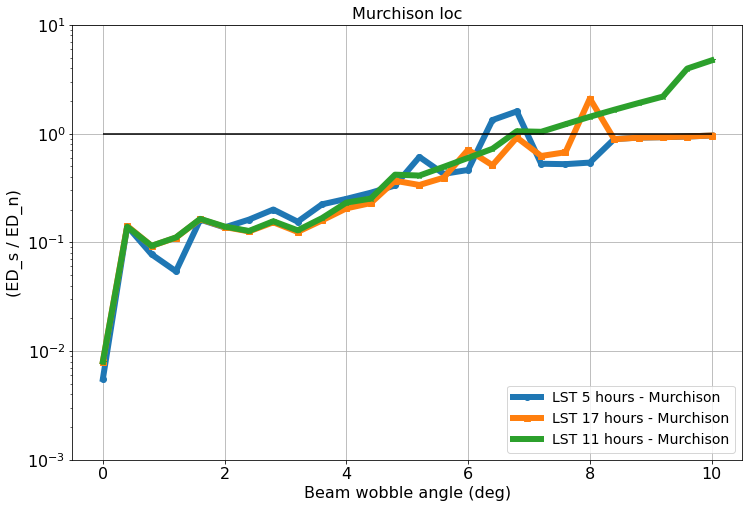

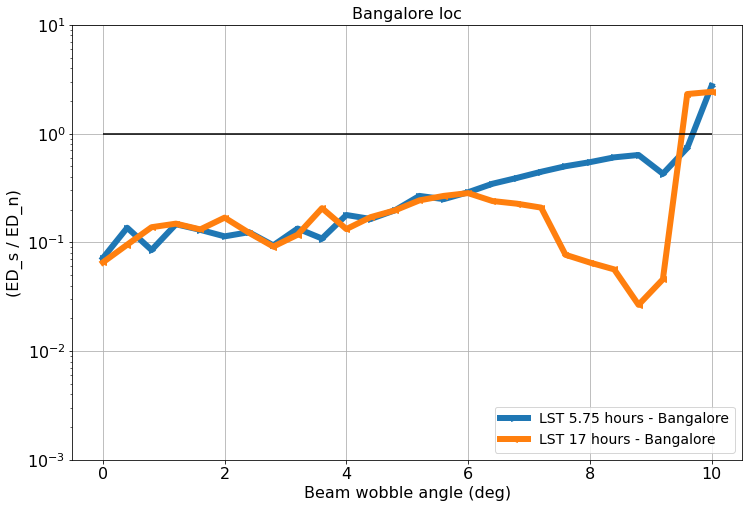

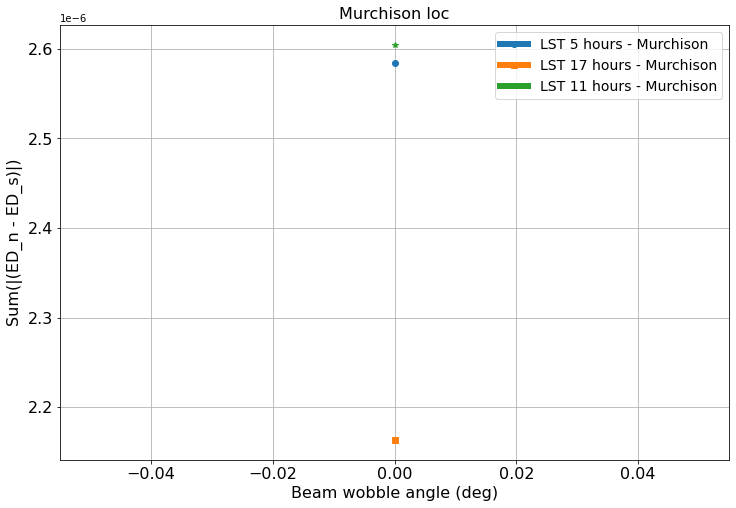

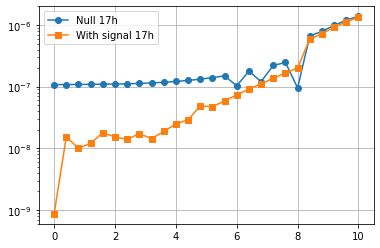

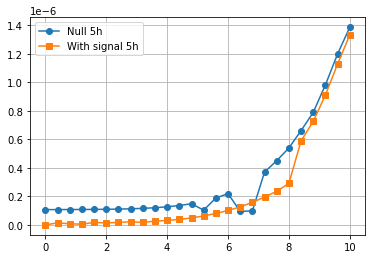

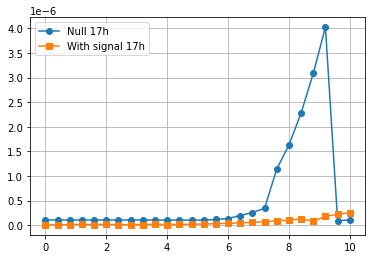

In [2]:
import numpy as np
import matplotlib.pyplot as plt


y1 = np.loadtxt("Different_time_loc_res_analysis/Murchison_Corrd_1dwobble_0.2res_ED_signal_2024-05-19 05:25:00.txt")
y2 = np.loadtxt("Different_time_loc_res_analysis/Murchison_Corrd_1dwobble_0.2res_ED_signal_2024-05-19 17:25:00.txt")
y3 = np.loadtxt("Different_time_loc_res_analysis/Murchison_Corrd_1dwobble_0.2res_ED_signal_2024-05-19 11:25:00.txt")
y4 = np.loadtxt("Final_graphs/ED_Signal_1dwobble.txt")
y5 = np.loadtxt("Different_time_loc_res_analysis/Bangalore_Corrd_1dwobble_0.2res_ED_signal_2012-05-19 08:45:00.txt")
y6 = np.loadtxt("Different_time_loc_res_analysis/Bangalore_Corrd_1dwobble_0.2res_ED_signal_2012-05-19 20:00:00.txt")


y1_null = np.loadtxt("Different_time_loc_res_analysis/Murchison_Corrd_1dwobble_0.2res_ED_Null_2024-05-19 05:25:00.txt")
y2_null = np.loadtxt("Different_time_loc_res_analysis/Murchison_Corrd_1dwobble_0.2res_ED_Null_2024-05-19 17:25:00.txt")
y3_null = np.loadtxt("Different_time_loc_res_analysis/Murchison_Corrd_1dwobble_0.2res_ED_Null_2024-05-19 11:25:00.txt")
y4_null = np.loadtxt("Final_graphs/ED_Null_1dwobble.txt")
y5_null = np.loadtxt("Different_time_loc_res_analysis/Bangalore_Corrd_1dwobble_0.2res_ED_Null_2012-05-19 08:45:00.txt")
y6_null = np.loadtxt("Different_time_loc_res_analysis/Bangalore_Corrd_1dwobble_0.2res_ED_Null_2012-05-19 20:00:00.txt")

print(len(y1), len(y2), len(y1_null), len(y2_null), len(y3), len(y3_null), len(y4), len(y4_null))

#___________________________________________________________________________________________________________

plt.figure(figsize=(12, 8))

plt.plot(2*np.arange(0, 5.2, 0.2), (y1 / y1_null) , label = "LST 5 hours - Murchison", marker = 'o', linewidth = 6)
plt.plot(2*np.arange(0, 5.2, 0.2), (y2 / y2_null) , label = "LST 17 hours - Murchison", marker = 's', linewidth = 6)
plt.plot(2*np.arange(0, 5.2, 0.2), (y3 / y3_null) , label = "LST 11 hours - Murchison", marker = '*', linewidth = 6)
plt.yscale('log')
plt.legend(loc = 'lower right', fontsize = 14)
plt.hlines(1.0, xmax= 10, xmin = 0, color = 'black')
plt.ylabel("(ED_s / ED_n)", fontsize = 16)
plt.xlabel("Beam wobble angle (deg)", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim([1e-3, 1e+1])
plt.title("Murchison loc", fontsize = 16)
plt.grid()
plt.show()

#___________________________________________________________________________________________________________

plt.figure(figsize=(12, 8))
#plt.plot(2*np.arange(0, 4.1, 0.1), (y4 / y4_null), label = "LST 3 hours - Bangalore", marker = 'P', linewidth = 6)
plt.plot(2*np.arange(0, 5.2, 0.2), (y5 / y5_null), label = "LST 5.75 hours - Bangalore", marker = '>', linewidth = 6)
plt.plot(2*np.arange(0, 5.2, 0.2), (y6 / y6_null), label = "LST 17 hours - Bangalore", marker = '<', linewidth = 6)

plt.yscale('log')
plt.legend(loc = 'lower right', fontsize = 14)
plt.hlines(1.0, xmax= 10, xmin = 0, color = 'black')
plt.ylabel("(ED_s / ED_n)", fontsize = 16)
plt.xlabel("Beam wobble angle (deg)", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title("Bangalore loc", fontsize = 16)
plt.ylim([1e-3, 1e+1])
plt.grid()
plt.show()

#___________________________________________________________________________________________________________

plt.figure(figsize=(12, 8))
plt.plot(np.sum(abs(y1_null - y1)) , label = "LST 5 hours - Murchison", marker = 'o', linewidth = 6)
plt.plot(np.sum(abs(y2_null - y2)) , label = "LST 17 hours - Murchison", marker = 's', linewidth = 6)
plt.plot(np.sum(abs(y3_null - y3)) , label = "LST 11 hours - Murchison", marker = '*', linewidth = 6)

plt.legend(loc = 'upper right', fontsize = 14)
#plt.hlines(1.0, xmax= 10, xmin = 0, color = 'black')
plt.ylabel("Sum(|(ED_n - ED_s)|)", fontsize = 16)
plt.xlabel("Beam wobble angle (deg)", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
#plt.ylim([-4, 3])
plt.title("Murchison loc", fontsize = 16)
plt.grid()
plt.show()

#___________________________________________________________________________________________________________


plt.plot(2*np.arange(0, 5.2, 0.2), y2_null, marker = 'o', label = "Null 17h")
plt.plot(2*np.arange(0, 5.2, 0.2), y2, marker = 's', label = "With signal 17h")
plt.grid()
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(2*np.arange(0, 5.2, 0.2), y1_null, marker = 'o', label = "Null 5h")
plt.plot(2*np.arange(0, 5.2, 0.2), y1, marker = 's', label = "With signal 5h")
plt.grid()
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(2*np.arange(0, 5.2, 0.2), y6_null, marker = 'o', label = "Null 17h")
plt.plot(2*np.arange(0, 5.2, 0.2), y6, marker = 's', label = "With signal 17h")
plt.legend()
plt.grid()
plt.show()



[1.1566617174072671e-08 8.1885923171587555e-09 1.8170047080413376e-08
 1.0312381852318647e-08 9.5350836474431434e-09 1.0640524427958850e-08
 2.1949446271515869e-08 1.5524624374145505e-08 1.0783149503749300e-08
 9.5292062491564404e-08 4.1030345260789891e-07 1.0551496851715733e-06
 1.8278067831484963e-06 2.4351722723849597e-06 3.1688333157158905e-06
 5.4489620293231176e-09 7.6024650044359891e-08 7.6099616613840896e-08
 1.2515979158213981e-08 7.6009026745802734e-08 7.6051863845240524e-08
 7.6132442563445468e-08 7.6209808493904485e-08 7.5808204047961783e-08
 2.5422149394587948e-08 7.6056726353330890e-08 0.0000000000000000e+00
 0.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00
 0.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00
 0.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00
 0.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00
 0.0000000000000000e+00 0.0000000000000000e+00]


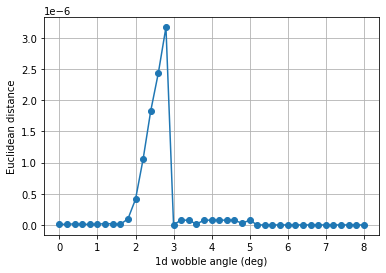

In [26]:
# With NSIDE = 32

print(eucl_dis_wob1d_stretch.transpose()[0])
# [1.1566617174072671e-08 8.1885923171587555e-09 1.8170047080413376e-08
#  1.0312381852318647e-08 9.5350836474431434e-09 1.0640524427958850e-08
#  2.1949446271515869e-08 1.5524624374145505e-08 1.0783149503749300e-08
#  9.5292062491564404e-08 4.1030345260789891e-07 1.0551496851715733e-06
#  1.8278067831484963e-06 2.4351722723849597e-06 3.1688333157158905e-06
#  5.4489620293231176e-09 7.6024650044359891e-08 7.6099616613840896e-08
#  1.2515979158213981e-08 7.6009026745802734e-08 7.6051863845240524e-08
#  7.6132442563445468e-08 7.6209808493904485e-08 7.5808204047961783e-08
#  2.5422149394587948e-08 7.6056726353330890e-08 0.0000000000000000e+00
#  0.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00
#  0.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00
#  0.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00
#  0.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00
#  0.0000000000000000e+00 0.0000000000000000e+00]


plt.plot(2* np.arange(0, 4.1, 0.1), eucl_dis_wob1d_stretch.transpose()[0], marker = 'o')
plt.xlabel("1d wobble angle (deg)")
plt.ylabel("Euclidean distance")
plt.grid()
plt.show()